# BERT-LSTM

## Imports and fixed SEED

In [10]:
import torch
from torchtext.legacy import data
import random
import numpy as np

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.enabled = False 
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# Only necessary for GPU
# If available, the tensors will be allocated to a GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load Pretrained BERT Tokenizer

The transformer has already been trained with a specific vocabulary, which means we need to train with the exact same vocabulary and also tokenize our data in the same way that the transformer did when it was initially trained.

We are using the BERT model which ignores casing. We get this by loading the pre-trained bert-base-uncased tokenizer.

In [12]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') 

The transformer was also trained with special tokens to mark the beginning and end of the sentence, as well as a standard padding and unknown token. We can also get these from the tokenizer.
- sep_token — The separator token, which is used when building a sequence from multiple sequences, e.g. two sequences for sequence classification or for a text and a question for question answering. It is also used as the last token of a sequence built with special tokens.
- cls_token — The classifier token which is used when doing sequence classification (classification of the whole sequence instead of per-token classification). It is the first token of the sequence when built with special tokens.

In [13]:
init_token = tokenizer.cls_token 
eos_token = tokenizer.sep_token
pad_token = tokenizer.pad_token
unk_token = tokenizer.unk_token

init_token_idx = tokenizer.cls_token_id
eos_token_idx = tokenizer.sep_token_id
pad_token_idx = tokenizer.pad_token_id
unk_token_idx = tokenizer.unk_token_id

max_input_length = tokenizer.max_model_input_sizes['bert-base-uncased']
print(max_input_length)

512


### Tokenize and Cut
We define a function to handle tokenization and cut down the number of tokens to a maximum length. The maximum length is 2 less than the actual maximum length. This is because we need to append two tokens to each sequence, one to the start and one to the end.

In [14]:
def tokenize_and_cut(sentence):
  # tokenize the sentence and cut down to maximum length
  tokens = tokenizer.tokenize(sentence) 
  tokens = tokens[:max_input_length-2]
  return tokens

## DataSet Definition

Here we define the Dataset Structure and load the training and test dataset as TabularDataset.

The columns PhraseId and SentenceId are artifacts of the raw Dataset-structure and can be omitted for training and testing.

The transformer expects the batch dimension to be first, so we set `batch_first = True`. 

As we already have the vocabulary for our text, provided by the transformer we set `use_vocab = False` to tell torchtext that we'll be handling the vocabulary side of things. We pass our `tokenize_and_cut` function as the tokenizer. The `preprocessing` argument is a function that takes in the example after it has been tokenized, this is where we will convert the tokens to their indexes. Finally, we define the special tokens - making note that we are defining them to be their index value and not their string value. This is because the sequences will already be converted into indexes.

In [15]:
# Create Field objects
PHRASE = data.Field(batch_first = True,
                  use_vocab = False,
                  tokenize = tokenize_and_cut,
                  preprocessing = tokenizer.convert_tokens_to_ids,
                  init_token = init_token_idx,
                  eos_token = eos_token_idx,
                  pad_token = pad_token_idx,
                  unk_token = unk_token_idx)
SENTIMENT = data.LabelField()

# Create tuples representing the columns
fields = [
  (None, None), # ignore PhraseId column
  (None, None), # ignore SentenceId column
  ('Phrase', PHRASE),
  ('Sentiment', SENTIMENT)
]

# Load the dataset in tsv format
train_ds, test_ds = data.TabularDataset.splits(
   path = './data',
   train = 'train.tsv',
   test = 'test_mapped.tsv',
   format = 'tsv',
   fields = fields,
   skip_header = True
)

## Train- and Validation-Split

Here we split the Data into Training and Validation-Set. We used the common split of 70/30 as it represents a good amount of training data, while at the same time having a rather large validation-set of 30%. This gives meaningful results in terms of generalization from the validation score.

Another important setting is the usage of stratification based on the sentiment-labels. This ensures an equal distriubtion of the labels in the training and validation set.

In [16]:
# Create validation dataset; splits 70/30 by default
train_ds, valid_ds = train_ds.split(split_ratio=0.7, 
                                    stratified=True, 
                                    strata_field='Sentiment', 
                                    random_state = random.seed(SEED))

print(f'Number of training examples: {len(train_ds)}')
print(f'Number of validation examples: {len(valid_ds)}')
print(f'Number of testing examples: {len(test_ds)}')

Number of training examples: 109241
Number of validation examples: 46819
Number of testing examples: 65327


## Creating the Vocabulary

Here only the vocabulary of the labels is built. 

Phrase vocabulary was already created in the Dataset Structure, using the pre-trained BERT.

**Note:** The vocabulary DataField "SENTIMENT" is not created from the training data to preserve the correct indexing "{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}", and instead a vector of key value pairs is provided. 

In [17]:
sentiment_labels = np.array(['0', '1', '2', '3', '4'])

#SENTIMENT.build_vocab(train_ds) # old version
SENTIMENT.build_vocab(sentiment_labels) # Custom indexing is necessary for correct mapping; {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}

print(f"Unique tokens in SENTIMENT vocabulary: {len(SENTIMENT.vocab)}")

Unique tokens in SENTIMENT vocabulary: 5


## Creation of the Iterators

The Iterators are use to yield one Batch of the Data at a time. 

It is notworthhy that the Batch-Size is a parameter that can be tuned.







In [18]:
BATCH_SIZE = 64 # 32, 128, 256, 512

# Creating the iterators
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_ds, valid_ds, test_ds), 
    batch_size = BATCH_SIZE,
    sort = False,
    sort_key = lambda x: len(x.Phrase),
    sort_within_batch = True,
    device = device)

## Model Definition

Instantiate a pretrained pytorch model from the pre-trained model configuration Bert-base-uncased.


Instead of using an embedding layer to get embeddings for our text, we'll be using the pre-trained transformer model. These embeddings will then be fed into a LSTM to produce a prediction for the sentiment of the input sentence. We get the embedding dimension size (called the `hidden_size`) from the transformer via its config attribute. The rest of the initialization is standard.

Within the forward pass, we wrap the transformer in a no_grad to ensure no gradients are calculated over this part of the model. 

In [19]:
from transformers import BertModel

bert = BertModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(   self, 
                    bert,
                    hidden_dim, 
                    output_dim, 
                    n_layers, 
                    bidirectional, 
                    dropout):
        
        super().__init__()
        
        # pretrained bert as embedding layer
        self.bert = bert
        
        embedding_dim = bert.config.to_dict()['hidden_size']
        
        # lstm-layer
        self.lstm = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           batch_first = True,
                           dropout = 0 if n_layers < 2 else dropout)
        
        # fully-connectet layer
        self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        #text = [batch size, sent len]
                
        with torch.no_grad():
            embedded = self.bert(text)[0]
                
        #embedded = [batch size, sent len, emb dim]

        _, (hidden, cell) = self.lstm(embedded)
        
        #hidden = [n layers * n directions, batch size, emb dim]
        #cell = [n layers * n directions, batch size, emb dim]
        
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
                
        #hidden = [batch size, hid dim]
        
        output = self.out(hidden)
        
        #output = [batch size, out dim]
        
        return output

## Setting the Hyper-Parameters 

The following parameters are used to initialize the model. 

In [21]:
HIDDEN_DIM = 256                  # 128, 512
OUTPUT_DIM = len(SENTIMENT.vocab)
N_LAYERS = 2                      # 4, 8
BIDIRECTIONAL = True              # False
DROPOUT = 0.25                    # 0.5, 0.75

model = LSTM(bert, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT)

We fix the Bert Layer parameters, thus they will not be trained and amount of trained parameters is much lower in this case.

In [22]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model including the Bert parameters has {count_parameters(model):,} trainable parameters')

The model including the Bert parameters has 113,163,013 trainable parameters


In [23]:
# freeze paramers (not train them)
for name, param in model.named_parameters():                
    if name.startswith('bert'):
        param.requires_grad = False
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 3,680,773 trainable parameters


Those are the weights and biases that will be trained:

In [24]:
# check the names of the trainable parameters
for name, param in model.named_parameters():                
    if param.requires_grad:
        print(name)

lstm.weight_ih_l0
lstm.weight_hh_l0
lstm.bias_ih_l0
lstm.bias_hh_l0
lstm.weight_ih_l0_reverse
lstm.weight_hh_l0_reverse
lstm.bias_ih_l0_reverse
lstm.bias_hh_l0_reverse
lstm.weight_ih_l1
lstm.weight_hh_l1
lstm.bias_ih_l1
lstm.bias_hh_l1
lstm.weight_ih_l1_reverse
lstm.weight_hh_l1_reverse
lstm.bias_ih_l1_reverse
lstm.bias_hh_l1_reverse
out.weight
out.bias


## Optimizer

Adaptive Momentum (Adam) Optimizer with included Momentum Term and Gradient Normalization. Regularization Term (weight decay) with small parameter lambda is additionally applied.

In [25]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

## Loss and Accuracy

For a multi-class classification task we use the CrossEntropy Loss and categorical accuracy as our performance metrics.

In [26]:
criterion = nn.CrossEntropyLoss()

# model and criterion tensor will be allocated to CPU/GPU
model = model.to(device)
criterion = criterion.to(device)

In [27]:
def categorical_accuracy(preds, y):
    
    # Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    
    top_pred = preds.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

## Definition of Training and Evaluation Method

These Methods represent one training epoch. For every epoch the train method gets called and iterates over each batch, whereafter the wheights are updated in the backward step based on the calculated loss.

(Forward pass, loss calculation, backpropagation, weight update)



In [28]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.Phrase)
        
        loss = criterion(predictions, batch.Sentiment)
        
        acc = categorical_accuracy(predictions, batch.Sentiment)
        
        loss.backward()
        
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

The evaluate Method calculates the pefromance of the Model on the validation set with the weights of the current epoch.

In [29]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:
        
            predictions = model(batch.Phrase)
            
            loss = criterion(predictions, batch.Sentiment)

            acc = categorical_accuracy(predictions, batch.Sentiment)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

## Training and Evaluation

Auxiliary Function, to calculate the duration of the training time for one full epoch.

In [30]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Here the final training loop is executed N times. N is therefore the amount of Training-Epochs.

Calls training and evaluation method in every epoch and saves the model with the highest evaluation accuracy.



In [31]:
N_EPOCHS = 10

best_valid_loss = float('inf')

# to track the average training loss and accuracy per epoch as the model trains
avg_train_losses = []
avg_train_accuracies = []
# to track the average validation loss and accuracy per epoch as the model trains
avg_valid_losses = []
avg_valid_accuracies = []

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model_BERT.pt')

    # calculate average loss over an epoch
    avg_train_losses.append(train_loss)
    avg_valid_losses.append(valid_loss)

    avg_train_accuracies.append(train_acc)
    avg_valid_accuracies.append(valid_acc)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 5m 1s
	Train Loss: 0.928 | Train Acc: 61.79%
	 Val. Loss: 0.854 |  Val. Acc: 64.66%
Epoch: 02 | Epoch Time: 5m 1s
	Train Loss: 0.855 | Train Acc: 64.48%
	 Val. Loss: 0.818 |  Val. Acc: 65.84%
Epoch: 03 | Epoch Time: 5m 1s
	Train Loss: 0.813 | Train Acc: 66.19%
	 Val. Loss: 0.800 |  Val. Acc: 66.61%
Epoch: 04 | Epoch Time: 5m 0s
	Train Loss: 0.780 | Train Acc: 67.55%
	 Val. Loss: 0.807 |  Val. Acc: 66.71%
Epoch: 05 | Epoch Time: 5m 1s
	Train Loss: 0.750 | Train Acc: 68.92%
	 Val. Loss: 0.822 |  Val. Acc: 66.30%
Epoch: 06 | Epoch Time: 5m 0s
	Train Loss: 0.722 | Train Acc: 70.00%
	 Val. Loss: 0.789 |  Val. Acc: 67.83%
Epoch: 07 | Epoch Time: 5m 1s
	Train Loss: 0.696 | Train Acc: 71.01%
	 Val. Loss: 0.784 |  Val. Acc: 68.10%
Epoch: 08 | Epoch Time: 5m 1s
	Train Loss: 0.674 | Train Acc: 72.02%
	 Val. Loss: 0.786 |  Val. Acc: 67.99%
Epoch: 09 | Epoch Time: 5m 0s
	Train Loss: 0.655 | Train Acc: 73.01%
	 Val. Loss: 0.802 |  Val. Acc: 67.60%
Epoch: 10 | Epoch Time: 5m 0

## Visualization

Finally we present a Visualization of the Training and Validation Score over the Epochs to determine a good stoping point.

Loss Visualization

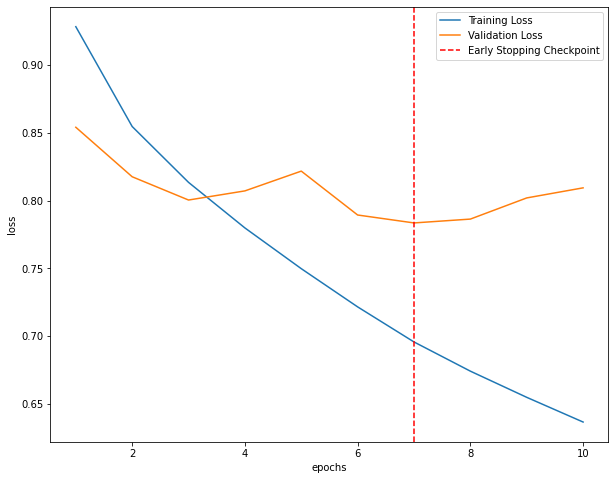

In [32]:
import matplotlib.pyplot as plt

# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(avg_train_losses)+1),avg_train_losses, label='Training Loss')
plt.plot(range(1,len(avg_valid_losses)+1),avg_valid_losses,label='Validation Loss')

# find position of lowest validation loss
minposs = avg_valid_losses.index(min(avg_valid_losses))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
#plt.ylim(0.5, 1) # consistent scale
#plt.xlim(0, len(avg_train_losses)+1) # consistent scale
#plt.grid(True)
plt.legend()
#plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

Accuracy Visualization

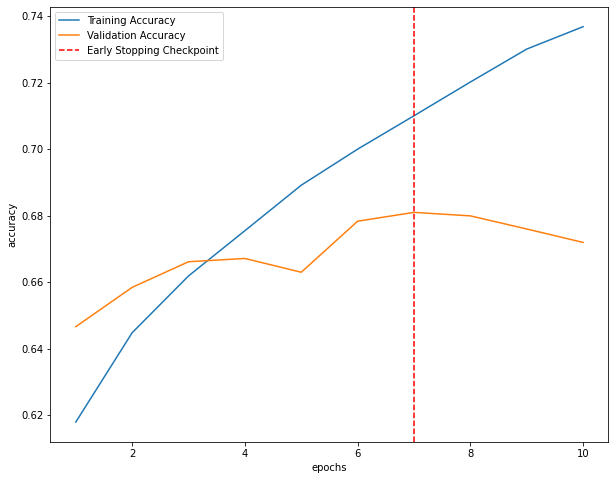

In [33]:
# visualize the loss as the network trained

fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(avg_train_accuracies)+1),avg_train_accuracies, label='Training Accuracy')
plt.plot(range(1,len(avg_valid_accuracies)+1),avg_valid_accuracies,label='Validation Accuracy')



# find position of lowest validation loss

minposs = avg_valid_accuracies.index(max(avg_valid_accuracies))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')
plt.xlabel('epochs')
plt.ylabel('accuracy')



#plt.grid(True)

plt.legend()
#plt.tight_layout()
plt.show()
fig.savefig('acc_plot.png', bbox_inches='tight')